<a href="https://colab.research.google.com/github/trinaxavier2001/SkinLesionClassification/blob/main/Swin_Model_softCrossEntropyLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

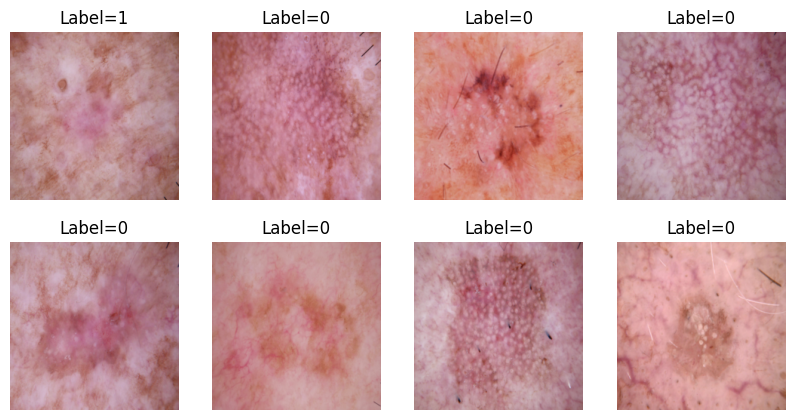

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import ViTForImageClassification
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 1) Load metadata + resolve paths
df = pd.read_csv('/content/drive/MyDrive/Skin_Disease_Model/metadata_with_image_descriptions.csv')
def resolve_path(image_id):
    p1 = f"/content/drive/MyDrive/Skin_Disease_Model/HAM10000_images_part_1/{image_id}.jpg"
    p2 = f"/content/drive/MyDrive/Skin_Disease_Model/HAM10000_images_part_2/{image_id}.jpg"
    return p1 if os.path.exists(p1) else p2
df['file_path'] = df['image_id'].apply(resolve_path)

# 2) Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

# 3) Pick two classes + sample 50 each, then assert distribution
classes_to_overfit = [0, 1]
sub = df[df['label'].isin(classes_to_overfit)]
sub = sub.groupby('label').sample(n=50, random_state=42).reset_index(drop=True)
counts = sub['label'].value_counts().to_dict()
assert counts[0] == 50 and counts[1] == 50, f"Expected 50/50, got {counts}"

# 4) Train/val split
train_df, val_df = train_test_split(sub, test_size=0.2, stratify=sub['label'], random_state=42)

# 5) Simple transform WITHOUT Normalize (to debug scaling issues)
IMG_SIZE = 224
debug_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),            # no Normalize
])

# 6) Dataset + loaders with num_workers=0
class TinyDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['file_path']).convert('RGB')
        img = self.transform(img)
        return img, row['label']

train_ds = TinyDataset(train_df, debug_transform)
val_ds   = TinyDataset(val_df,   debug_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# 7) Sanity‐check: grab one batch and plot images+labels
batch_imgs, batch_lbls = next(iter(train_loader))
fig, axes = plt.subplots(2,4, figsize=(10,5))
for img, lbl, ax in zip(batch_imgs, batch_lbls, axes.flatten()):
    ax.imshow(img.permute(1,2,0))
    ax.set_title(f"Label={lbl.item()}")
    ax.axis('off')
plt.show()

In [2]:
import os
import random
import wandb
import torch
import numpy as np
import pandas as pd
from PIL import Image
import timm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from timm.data import Mixup
from tqdm.auto import tqdm

In [3]:
# 📌 Config
BATCH_SIZE = 16
IMG_SIZE   = 224
HEAD_LR    = 5e-3
FULL_LR    = 1e-4
EPOCHS     = 40
PATIENCE   = 8
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = 'swin_base_patch4_window7_224'
OUTPUT_DIR = '/content/drive/MyDrive/swin_skin_model'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) W&B Init


In [4]:
# 2) Load & resolve paths
df = pd.read_csv('/content/drive/MyDrive/Skin_Disease_Model/metadata_with_image_descriptions.csv')
def resolve_path(image_id):
    p1 = f"/content/drive/MyDrive/Skin_Disease_Model/HAM10000_images_part_1/{image_id}.jpg"
    p2 = f"/content/drive/MyDrive/Skin_Disease_Model/HAM10000_images_part_2/{image_id}.jpg"
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

df['file_path'] = df['image_id'].apply(resolve_path)
df.dropna(subset=['file_path'], inplace=True)

# 3) Encode & split
df['label'] = LabelEncoder().fit_transform(df['dx'])
train_df, tmp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(tmp, test_size=1/3, stratify=tmp['label'], random_state=42)
num_classes = train_df['label'].nunique()

In [7]:
# 4) Transforms
light_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
moderate_tfm = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
heavy_tfm = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(),
])

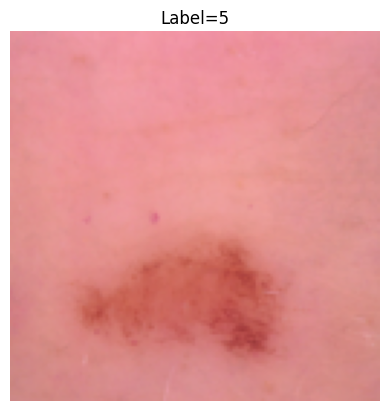

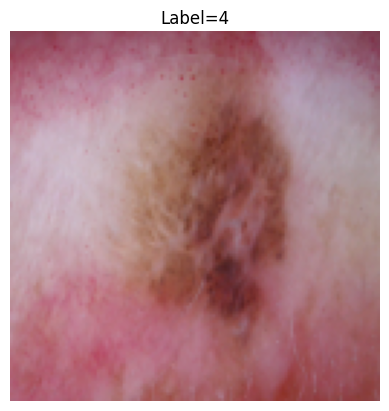

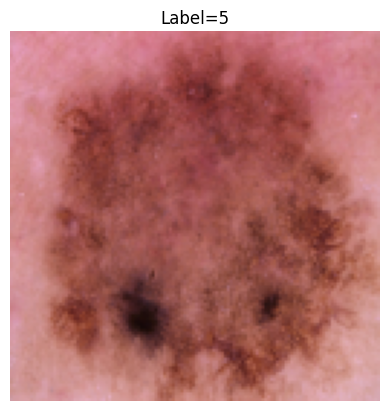

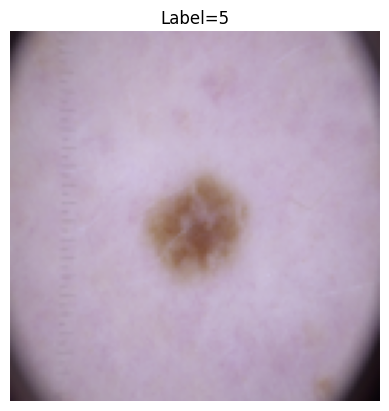

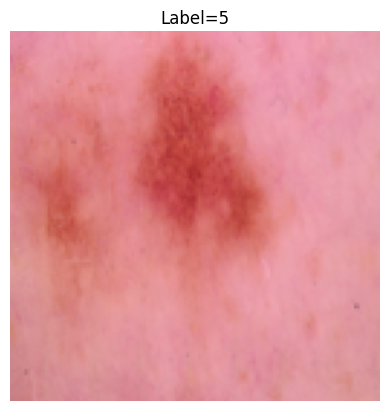

In [ ]:

# visualize 5 random examples
for idx in random.sample(list(train_df.index), 5):
    img = Image.open(train_df.loc[idx,'file_path']).convert('RGB').resize((128,128))
    plt.title(f"Label={train_df.loc[idx,'label']}"); plt.imshow(img); plt.axis('off'); plt.show()

In [8]:
# 5) Dataset
class SkinLesionDataset(Dataset):
    def __init__(self, df, tfm):
        self.df, self.tfm = df.reset_index(drop=True), tfm
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.file_path).convert('RGB')
        return self.tfm(img), row.label

# 6) Weighted sampler
counts = train_df['label'].value_counts().sort_index().values
class_weights = 1.0 / counts
sw = class_weights[train_df['label'].values]
sampler = WeightedRandomSampler(sw, len(sw), replacement=True)

# 7) DataLoaders
train_ds = SkinLesionDataset(train_df, light_tfm)
val_ds   = SkinLesionDataset(val_df,   light_tfm)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [9]:
# 8) Model + loss + Mixup
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(DEVICE)
for p in model.parameters(): p.requires_grad=False
for p in model.head.parameters(): p.requires_grad=True

def soft_target_cross_entropy(logits, soft_targets):
    log_probs = F.log_softmax(logits, dim=1)
    return -(soft_targets * log_probs).sum(dim=1).mean()

train_criterion = soft_target_cross_entropy
class_wt_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
val_criterion   = nn.CrossEntropyLoss(weight=class_wt_tensor)

mixup_fn = Mixup(
    mixup_alpha=0.2, cutmix_alpha=1.0,
    prob=1.0, switch_prob=0.5,
    label_smoothing=0.1, num_classes=num_classes
)

# 9) Confusion‐matrix helper
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, epoch):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False)
    plt.title(f'Confusion Matrix Epoch {epoch}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

→ Resuming from /content/drive/MyDrive/swin_skin_model/best.pth


<ipython-input-18-d355d10a68dc>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=DEVICE)


→ Resumed at epoch 3, best_f1=0.9115


[Val]   E4: 100%|██████████| 126/126 [05:59<00:00,  2.85s/it]


Epoch 04 | train_loss: 0.9273, train_acc: 0.6628, train_f1: 0.6627 | val_loss: 0.5254, val_acc: 0.9046, val_f1: 0.9061


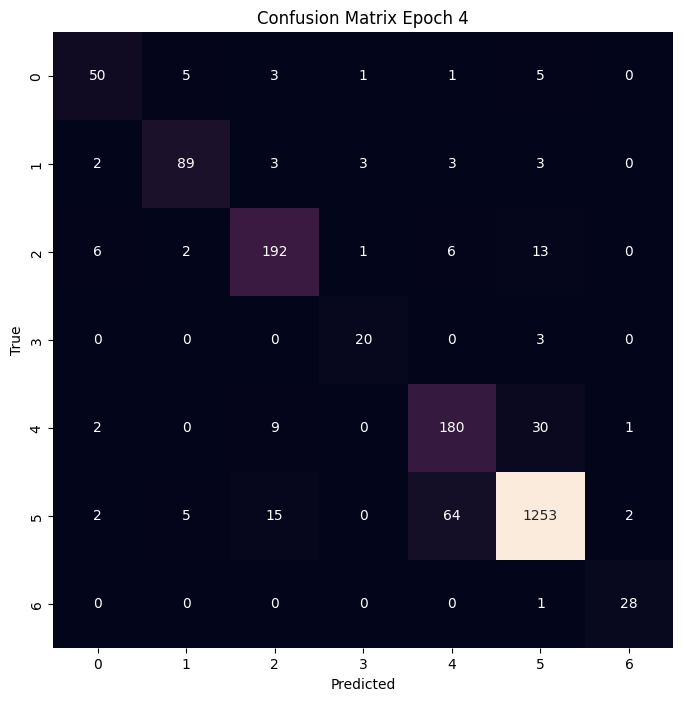

[Val]   E5: 100%|██████████| 126/126 [00:30<00:00,  4.14it/s]


Epoch 05 | train_loss: 0.8316, train_acc: 0.6725, train_f1: 0.6724 | val_loss: 0.5364, val_acc: 0.9071, val_f1: 0.9077


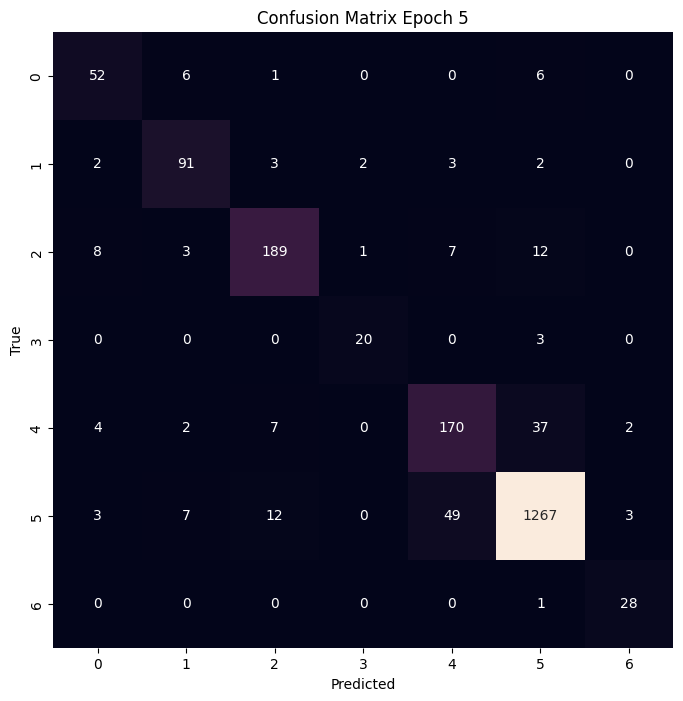

[Val]   E6: 100%|██████████| 126/126 [00:32<00:00,  3.85it/s]


Epoch 06 | train_loss: 0.8113, train_acc: 0.6767, train_f1: 0.6766 | val_loss: 0.5153, val_acc: 0.9136, val_f1: 0.9135


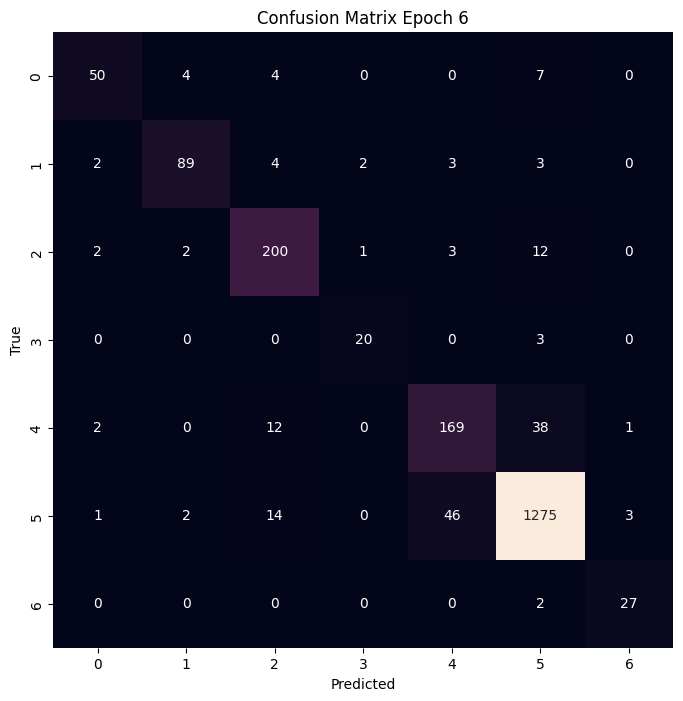

 New best val_f1: 0.9135 → checkpoint saved.


[Val]   E7: 100%|██████████| 126/126 [00:29<00:00,  4.20it/s]


Epoch 07 | train_loss: 0.8301, train_acc: 0.6873, train_f1: 0.6871 | val_loss: 0.5070, val_acc: 0.9086, val_f1: 0.9082


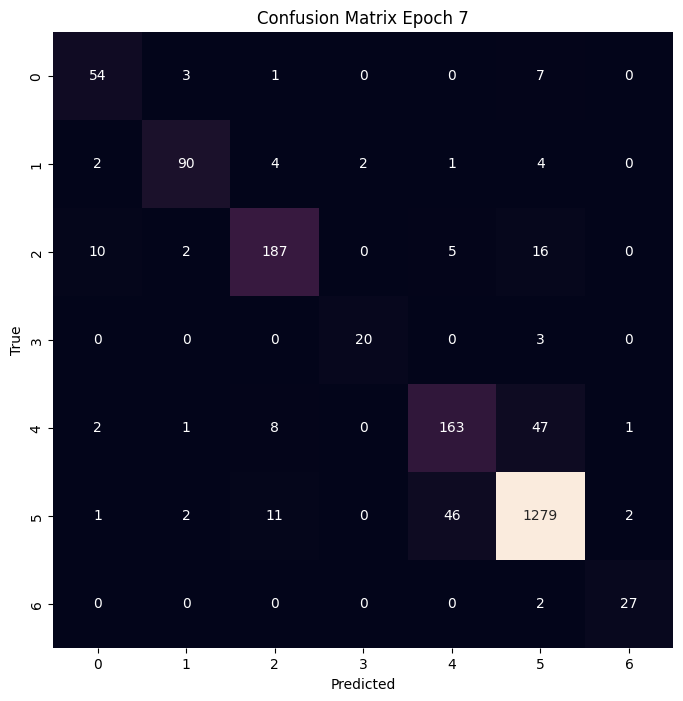

[Val]   E8: 100%|██████████| 126/126 [00:30<00:00,  4.16it/s]


Epoch 08 | train_loss: 0.8337, train_acc: 0.6847, train_f1: 0.6846 | val_loss: 0.5220, val_acc: 0.9081, val_f1: 0.9070


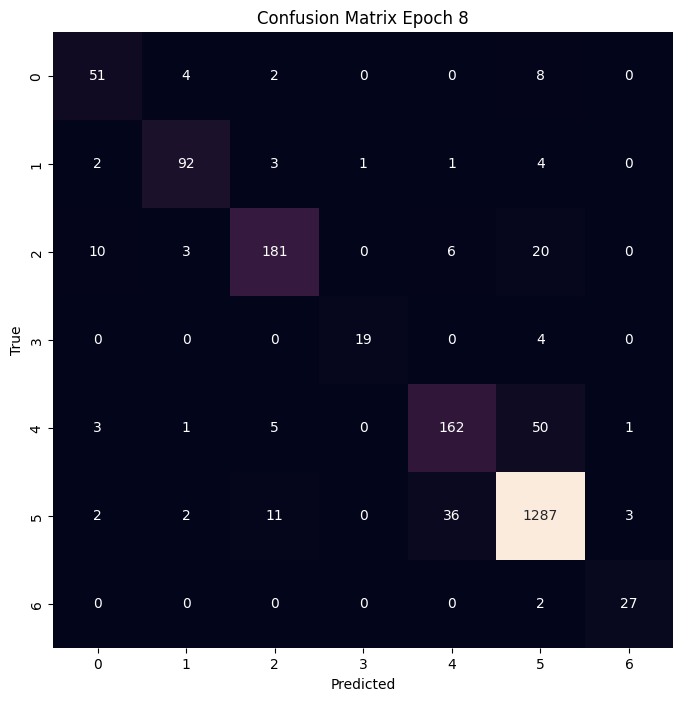

[Val]   E9: 100%|██████████| 126/126 [00:31<00:00,  4.05it/s]


Epoch 09 | train_loss: 0.8262, train_acc: 0.6770, train_f1: 0.6769 | val_loss: 0.5093, val_acc: 0.9106, val_f1: 0.9099


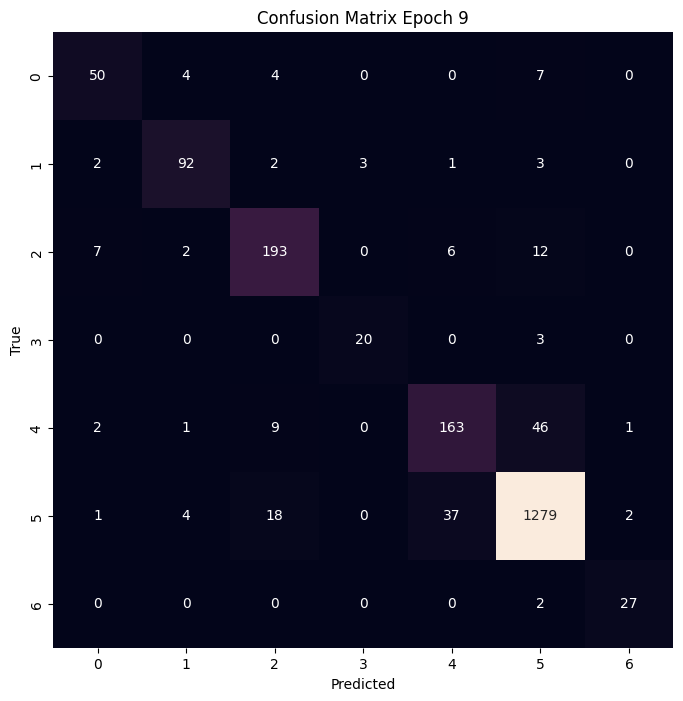

[Val]   E10: 100%|██████████| 126/126 [00:30<00:00,  4.17it/s]


Epoch 10 | train_loss: 0.8191, train_acc: 0.6743, train_f1: 0.6741 | val_loss: 0.4993, val_acc: 0.9036, val_f1: 0.9051


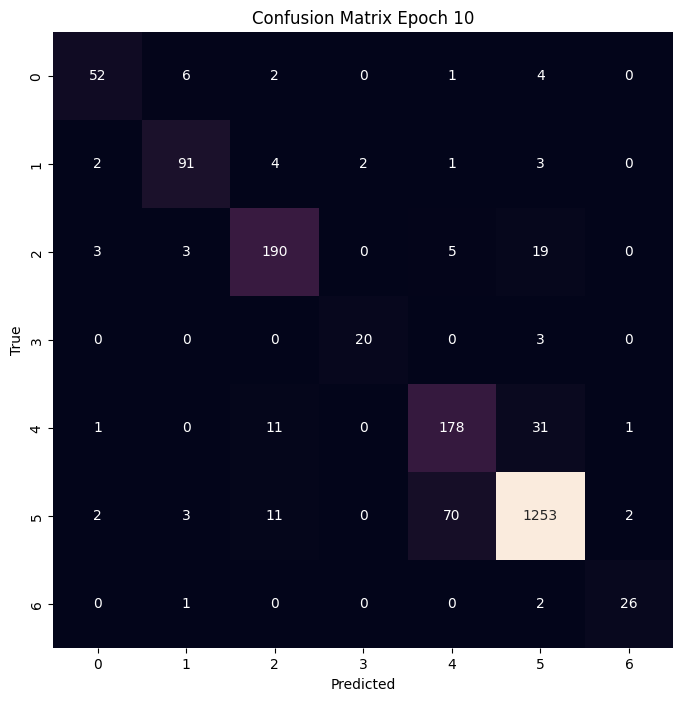

[Val]   E11: 100%|██████████| 126/126 [00:31<00:00,  3.97it/s]


Epoch 11 | train_loss: 0.8213, train_acc: 0.6300, train_f1: 0.6299 | val_loss: 0.4695, val_acc: 0.9091, val_f1: 0.9088


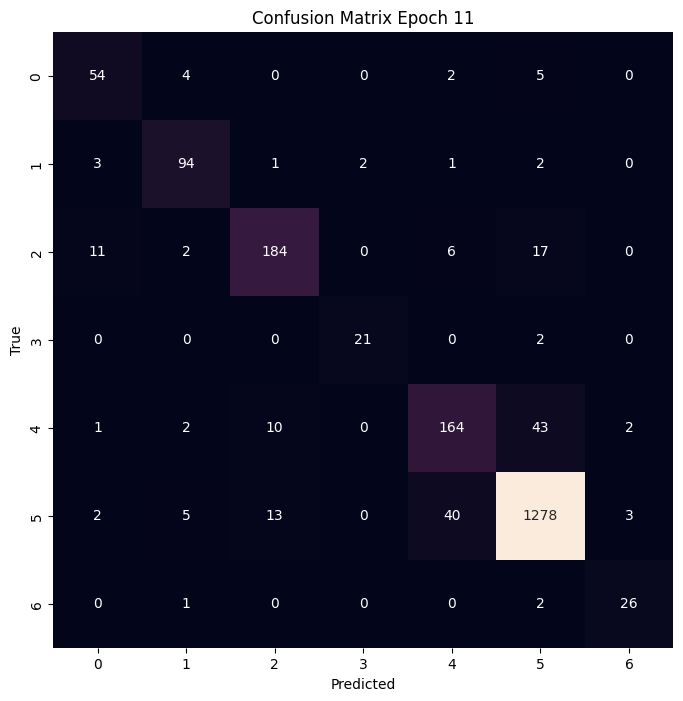

[Val]   E12: 100%|██████████| 126/126 [00:31<00:00,  4.02it/s]


Epoch 12 | train_loss: 0.8512, train_acc: 0.6529, train_f1: 0.6526 | val_loss: 0.4562, val_acc: 0.8972, val_f1: 0.8991


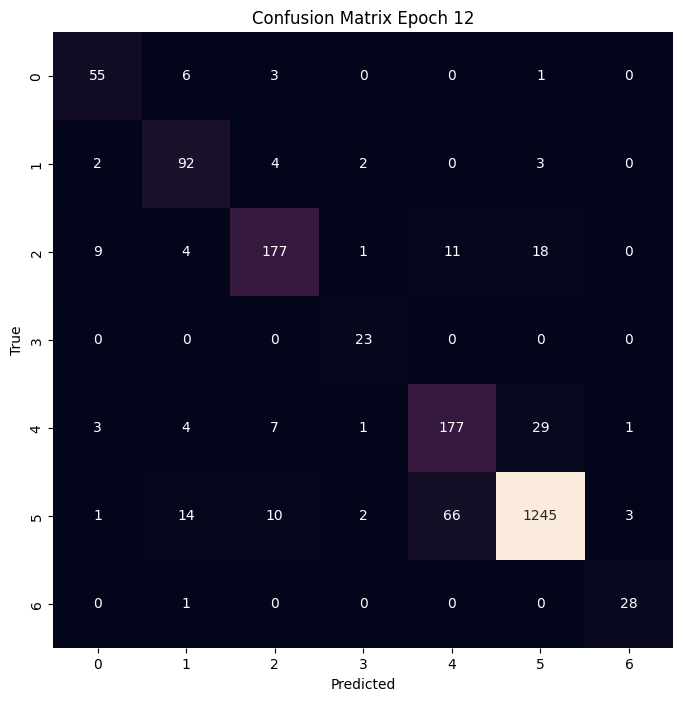

[Val]   E13: 100%|██████████| 126/126 [00:29<00:00,  4.21it/s]


Epoch 13 | train_loss: 0.8989, train_acc: 0.6545, train_f1: 0.6540 | val_loss: 0.5383, val_acc: 0.8612, val_f1: 0.8653


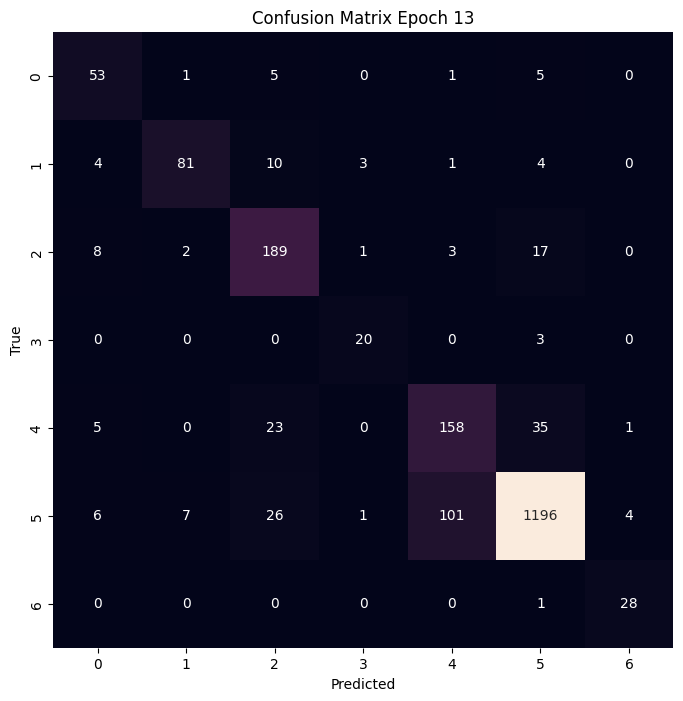

[Val]   E14: 100%|██████████| 126/126 [00:30<00:00,  4.08it/s]


Epoch 14 | train_loss: 0.9078, train_acc: 0.6083, train_f1: 0.6079 | val_loss: 0.5742, val_acc: 0.8133, val_f1: 0.8270


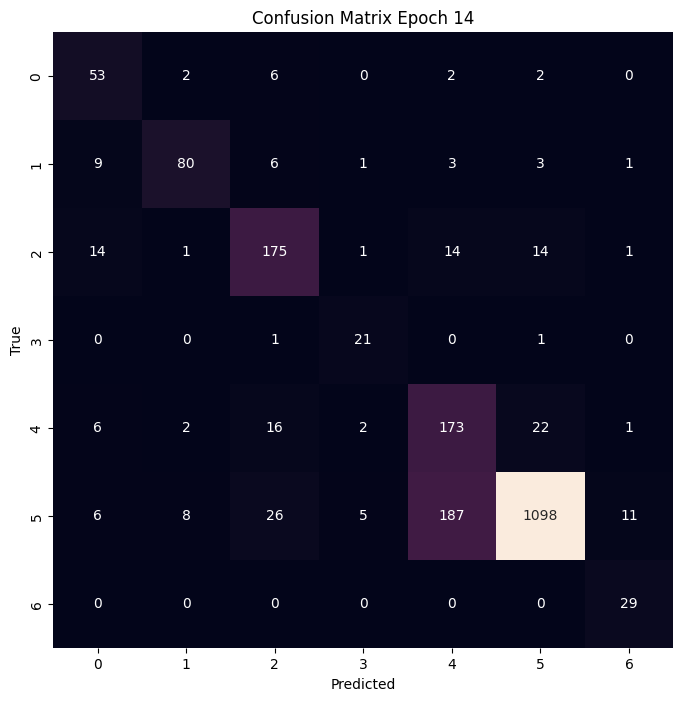

Early stopping at epoch 14


In [18]:
import os, torch

DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=HEAD_LR,
    weight_decay=1e-2
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=HEAD_LR,
    steps_per_epoch=len(train_loader),
    epochs=3         # match the epochs argument you used originally
)
ckpt_path = os.path.join(OUTPUT_DIR, 'best.pth')

if os.path.isfile(ckpt_path):
    print(f"→ Resuming from {ckpt_path}")
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)

    # restore model + optimizer + scheduler
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optim'])
    scheduler.load_state_dict(checkpoint['sched'])

    # pick up metrics & epoch
    best_f1     = checkpoint['best_f1']
    patience    = checkpoint['patience']
    start_epoch = checkpoint['epoch'] + 1
    print(f"→ Resumed at epoch {checkpoint['epoch']}, best_f1={best_f1:.4f}")
else:
    print("→ No checkpoint found, training from scratch")
    best_f1     = 0.0
    patience    = 0
    start_epoch = 1
patience = 0

for epoch in range(start_epoch, EPOCHS+1):
    # Phase 1: epochs 1–3
    if epoch == 1:
        train_ds.tfm, mixup_fn.prob = light_tfm, 0.0
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=HEAD_LR, weight_decay=1e-2
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=HEAD_LR,
            steps_per_epoch=len(train_loader),
            epochs=3
        )

    # Phase 2: epochs 4–6
    elif epoch == 4:
        train_ds.tfm, mixup_fn.prob = light_tfm, 0.5
        for p in model.layers[-1].parameters(): p.requires_grad=True
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=HEAD_LR*0.2, weight_decay=1e-2
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=HEAD_LR,
            steps_per_epoch=len(train_loader),
            epochs=3
        )

    # Phase 3: epochs 5–6
    elif 5 <= epoch < 7:
        train_ds.tfm, mixup_fn.prob = moderate_tfm, 0.7
        # keep optimizer/scheduler

    # Phase 4: epoch 7+
    elif epoch == 7:
        train_ds.tfm, mixup_fn.prob = heavy_tfm, 1.0
        for p in model.parameters(): p.requires_grad=True
        optimizer = torch.optim.AdamW(model.parameters(), lr=FULL_LR, weight_decay=1e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=FULL_LR,
            steps_per_epoch=len(train_loader),
            epochs=(EPOCHS-6)
        )

    # — TRAIN —
    model.train()
    tloss = correct = total = 0
    train_preds, train_labels = [], []
    for x,y in tqdm(train_loader, desc=f"[Train] E{epoch}"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        y_hard = y.clone()
        x, y_soft = mixup_fn(x,y)
        optimizer.zero_grad()
        out = model(x)
        loss = train_criterion(out, y_soft)
        loss.backward(); optimizer.step(); scheduler.step()

        tloss += loss.item()*y_hard.size(0)
        preds = out.argmax(1)
        correct += (preds==y_hard).sum().item()
        total += y_hard.size(0)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(y_hard.cpu().numpy())

    train_loss = tloss/total
    train_acc  = correct/total
    train_f1   = f1_score(train_labels, train_preds, average="weighted")

    # — VALIDATE —
    model.eval()
    vloss = vcorrect = vtotal = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for x,y in tqdm(val_loader, desc=f"[Val]   E{epoch}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x); loss = val_criterion(out,y)
            vloss    += loss.item()*y.size(0)
            preds    = out.argmax(1)
            vcorrect += (preds==y).sum().item()
            vtotal   += y.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    val_loss = vloss/vtotal
    val_acc  = vcorrect/vtotal
    val_f1   = f1_score(val_labels, val_preds, average="weighted")

    # — Print & Log —
    print(f"Epoch {epoch:02d} | "
          f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, train_f1: {train_f1:.4f} | "
          f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, val_f1: {val_f1:.4f}")

    # confusion matrix on clean val
    plot_confusion_matrix(val_labels, val_preds, epoch)

    # — Checkpoint & Early Stop —
    if val_f1 > best_f1:
        best_f1, patience = val_f1, 0
        ckpt = {
            'epoch':    epoch,
            'model':    model.state_dict(),
            'optim':    optimizer.state_dict(),
            'sched':    scheduler.state_dict(),
            'best_f1':  best_f1,
            'patience': patience
        }
        torch.save(ckpt, ckpt_path)
        print(f" New best val_f1: {val_f1:.4f} → checkpoint saved.")

    else:
        patience += 1
        if patience >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

In [19]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import f1_score
from tqdm import tqdm

BATCH_SIZE   = 32
NUM_WORKERS  = 2

# --- 1) Dataset class ---
class SkinLesionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df        = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.file_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, row.label

# --- 2) Instantiate test_loader ---
#   (use the same validation transforms you used for val_loader)
test_ds = SkinLesionDataset(test_df, transform=moderate_tfm)  # or heavy_tfm/light_tfm as appropriate
test_loader = DataLoader(
    test_ds,
    batch_size= BATCH_SIZE,    # e.g. 32
    shuffle=False,
    num_workers=NUM_WORKERS,   # e.g. 4
    pin_memory=True
)

# --- 3) Run test evaluation ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE).eval()

test_loss  = 0.0
correct    = 0
total      = 0
all_preds  = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="[Test]"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out  = model(x)
        loss = val_criterion(out, y)           # your validation criterion
        test_loss  += loss.item() * y.size(0)

        preds = out.argmax(dim=1)
        correct   += (preds == y).sum().item()
        total     += y.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# compute metrics
test_loss /= total
test_acc   = correct / total
test_f1    = f1_score(all_labels, all_preds, average="weighted")

print(f"Test Loss: {test_loss:.4f} | "
      f"Test Acc:  {test_acc:.4f} | "
      f"Test F1:   {test_f1:.4f}")




[Test]: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]

Test Loss: 0.6159 | Test Acc:  0.7964 | Test F1:   0.8124


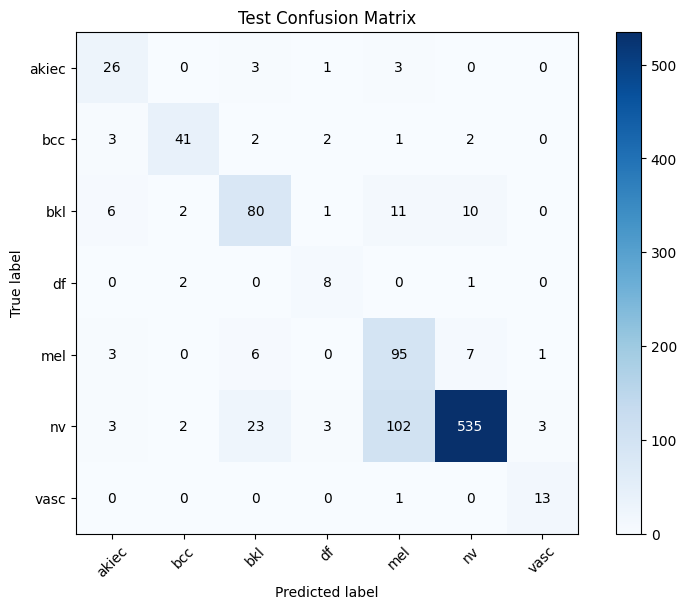

In [20]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) rebuild the encoder and class_names
le = LabelEncoder().fit(df['dx'])      # df is your full metadata DataFrame
class_names = le.classes_.tolist()     # e.g. ['akiec','bcc',…,'vasc']
num_classes  = len(class_names)

# 2) compute the matrix
cm = confusion_matrix(all_labels, all_preds)

# 3) plot it
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.colorbar()

ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

# annotate each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
